In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, forecast_by_week, train_test_split, evaluate_R_forecasts, process_R_results
from PythonFiles.PlottingFunctions import plot_coverage, print_forecasts_by_week, hyperparameter_boxplots, plot_model_results_by_hp,\
hp_color_plot, plot_forecast_entry
from PythonFiles.Configuration import Configuration
from PythonFiles.HpTuning import get_data, objectiveFNN
from datetime import datetime
import mxnet as mx
from gluonts.mx import Trainer, DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
mx.random.seed(0)
np.random.seed(0)
selected_regions = ['SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg', 'SK München']
influenza_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/Notebooks/DataProcessing/influenza.csv", sep=',')

data_splits_dict, base_df = get_data(truncate=False, with_features=True)
locations = list(influenza_df.location.unique())
train = data_splits_dict["with_features_2001"][0]
test = data_splits_dict["with_features_2001"][1]
config = Configuration()

# R Code

In [2]:
results_df = pd.read_csv("/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/results.csv", sep=',')

In [3]:
processed_df = process_R_results(config, results_df, influenza_df)

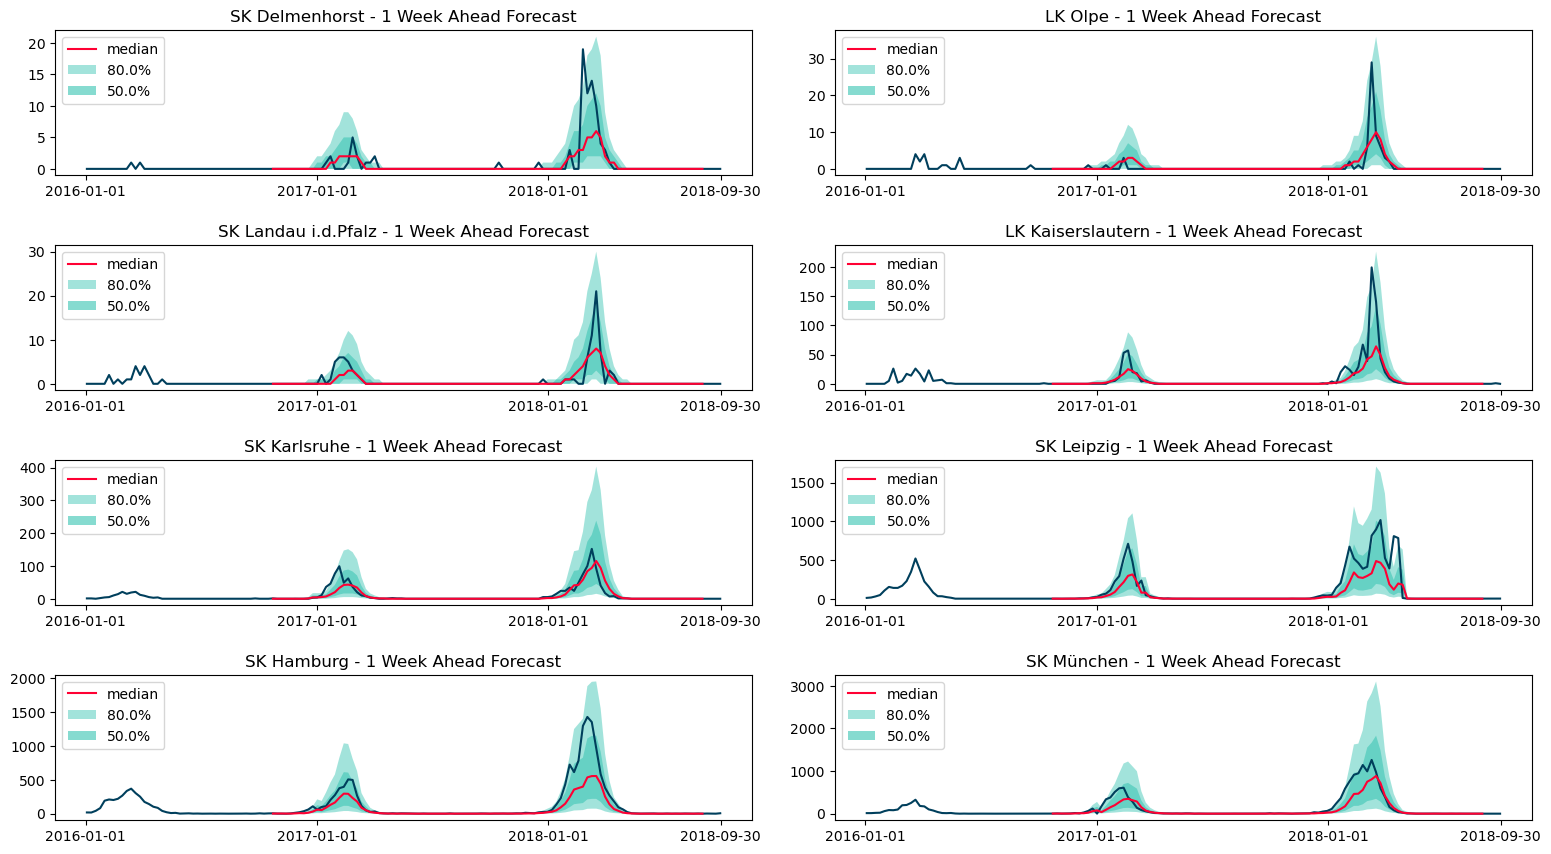

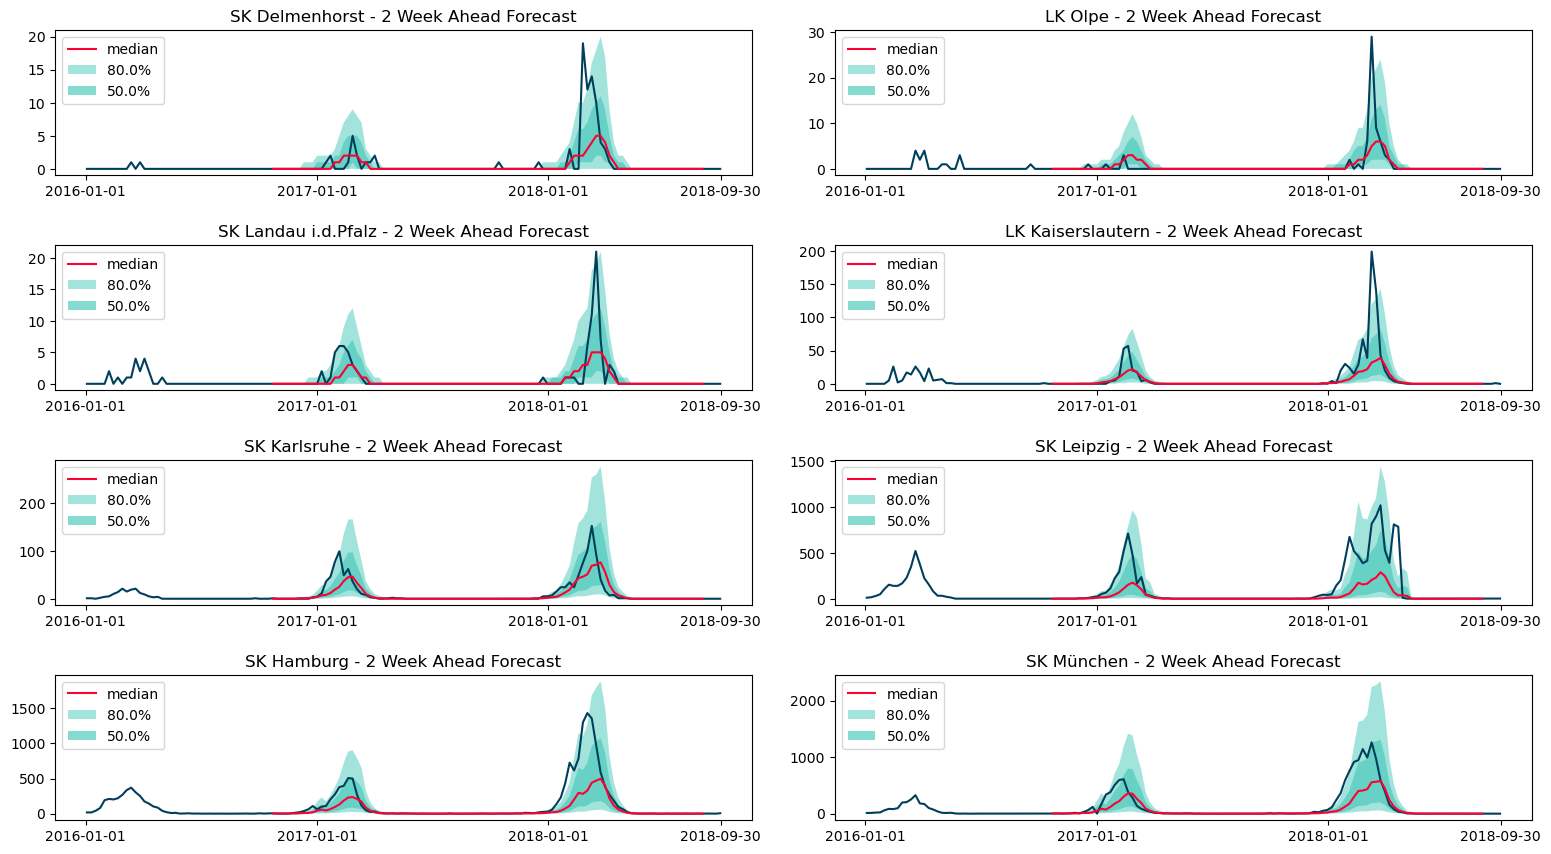

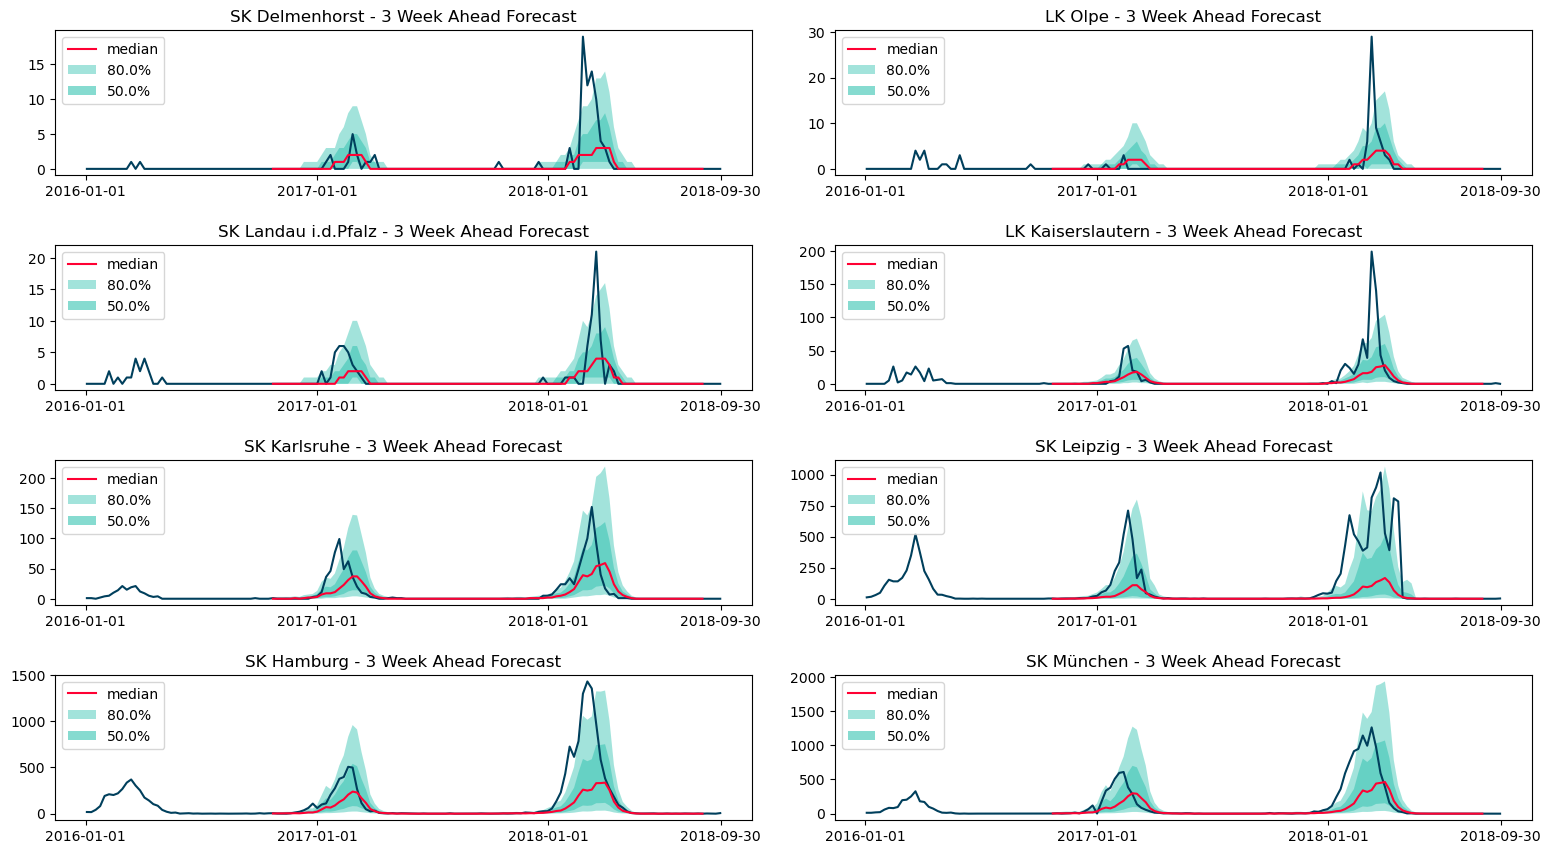

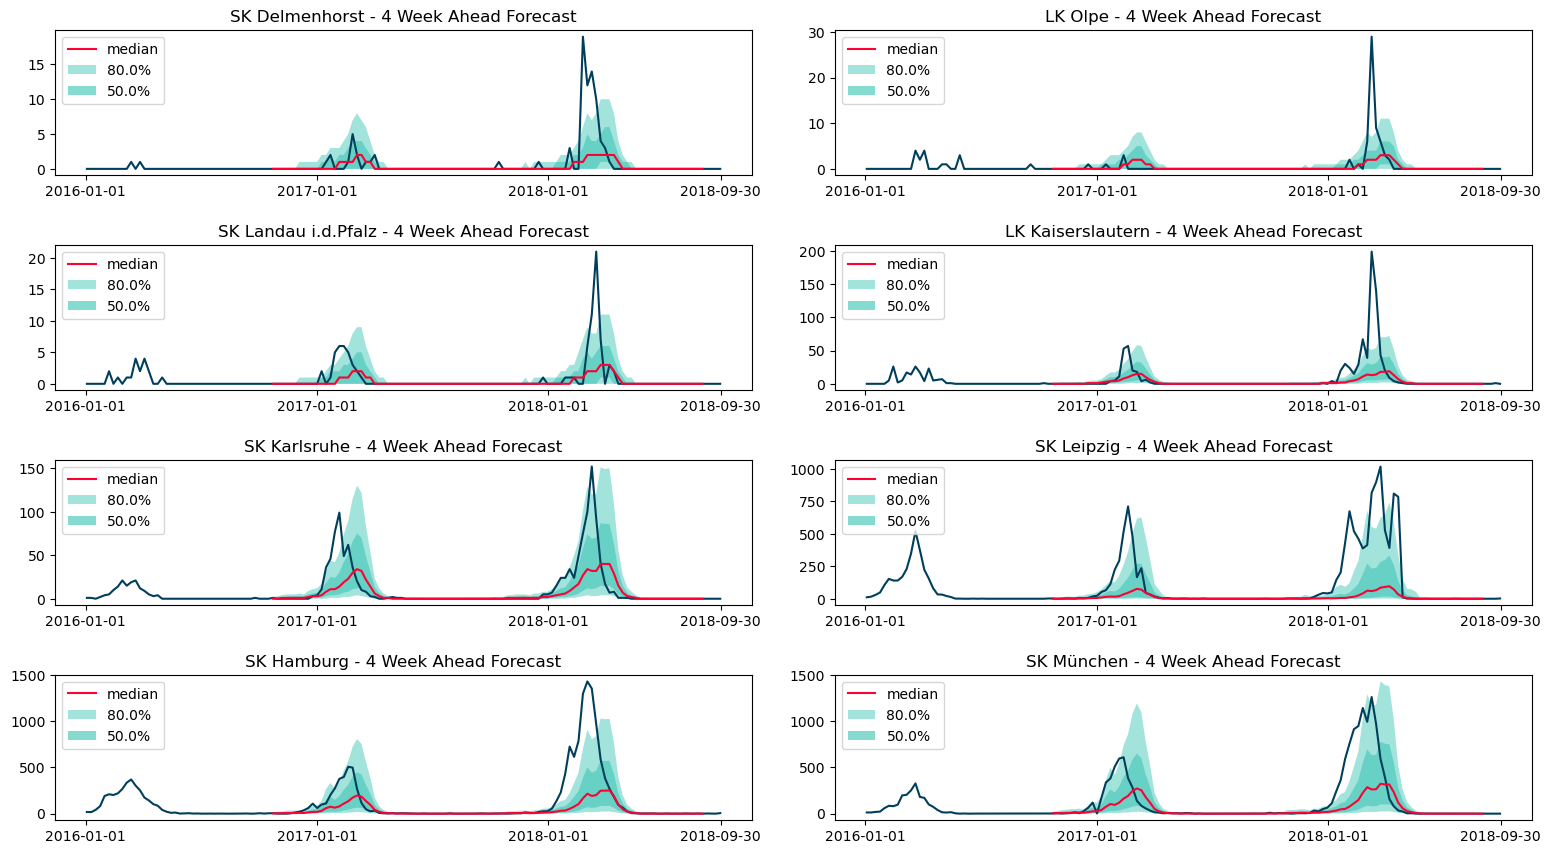

In [4]:

'''
df = df_dict["hhh4"][2]
selected_regions = ['SK München','SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg']
for region in selected_regions:
    plot_forecast_entry(config, df.loc[df["location"]==region], show_mean=False,ax=plt, prediction_intervals=(50.0, 80.0, 95.0), meancolor=config.colors[1],\
                        mediancolor=config.colors[1], fillcolor=config.colors[2], R_entry=True) 
    filter_index = (influenza_df["location"]==region) & (influenza_df.date >=datetime(2016,1,1)) & (influenza_df.date <=config.test_end_time)
    plt.plot(influenza_df.loc[filter_index, "date"], influenza_df.loc[filter_index,"value"], c= config.colors[0])
    plt.xticks([datetime(2016,1,1), datetime(2017,1,1), datetime(2018,1,1), config.test_end_time], rotation=0, ha="center")
    plt.title(f"{region}")
    plt.legend()
    plt.show()'''
df_dict = {"hhh4":{1:processed_df[processed_df.WeekAhead == 1].copy(),
           2:processed_df[processed_df.WeekAhead == 2].copy(),
           3:processed_df[processed_df.WeekAhead == 3].copy(),
           4:processed_df[processed_df.WeekAhead == 4].copy()}}
print_forecasts_by_week(config, base_df, df_dict, selected_regions[:], [1,2,3,4], plot_begin_at_trainstart=datetime(2016,1,1,0,0,0))

In [5]:
evaluator_df = evaluate_R_forecasts(config, df_dict["hhh4"], locations, processed_df)

Evaluating 1/4 -- 2023-05-23 08:53:09.023144
Evaluating 2/4 -- 2023-05-23 08:54:14.264664
Evaluating 3/4 -- 2023-05-23 08:55:16.843258
Evaluating 4/4 -- 2023-05-23 08:56:19.441888


0       342.829701
1       421.263452
2       512.502642
3       601.897897
4              NaN
           ...    
1643           NaN
1644           NaN
1645           NaN
1646           NaN
1647           NaN
Name: mean_WIS, Length: 1648, dtype: float64


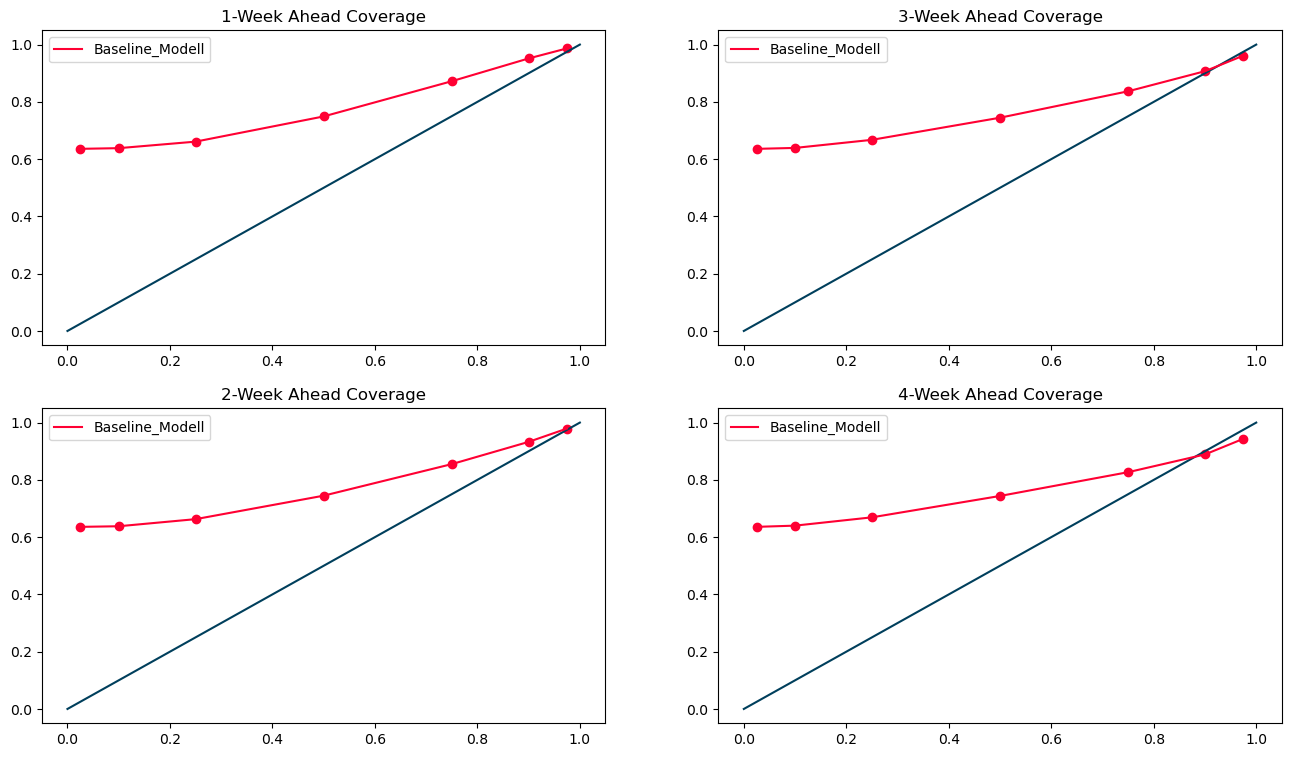

In [6]:
#print(evaluator_df[evaluator_df["mean_WIS"]!=0])
#print(evaluator_df[[col for col in evaluator_df.columns if "Coverage" in col]])
#print(evaluator_df[[col for col in evaluator_df.columns if "Quantile" in col]])
print(evaluator_df["mean_WIS"])
eval_dict = {"Baseline_Modell": evaluator_df}
plot_coverage(config, eval_dict, locations=None)

# Defaults

In [7]:
results_dict = np.load('/home/reffert/DeepAR_InfluenzaForecast/HyperparameterFiles/default_models.npy',allow_pickle='TRUE').item()

Running evaluation: 411it [00:03, 129.25it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 112.23it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:04, 96.14it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 109.10it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:03, 118.59it/s]

DeepAR
          item_id    mean_WIS
0  aggregated {1}  279.029649
0  aggregated {2}  394.798714
0  aggregated {3}  491.593813
0  aggregated {4}  577.026590
FNN
          item_id    mean_WIS
0  aggregated {1}  295.890129
0  aggregated {2}  464.186409
0  aggregated {3}  627.079232
0  aggregated {4}  783.187174


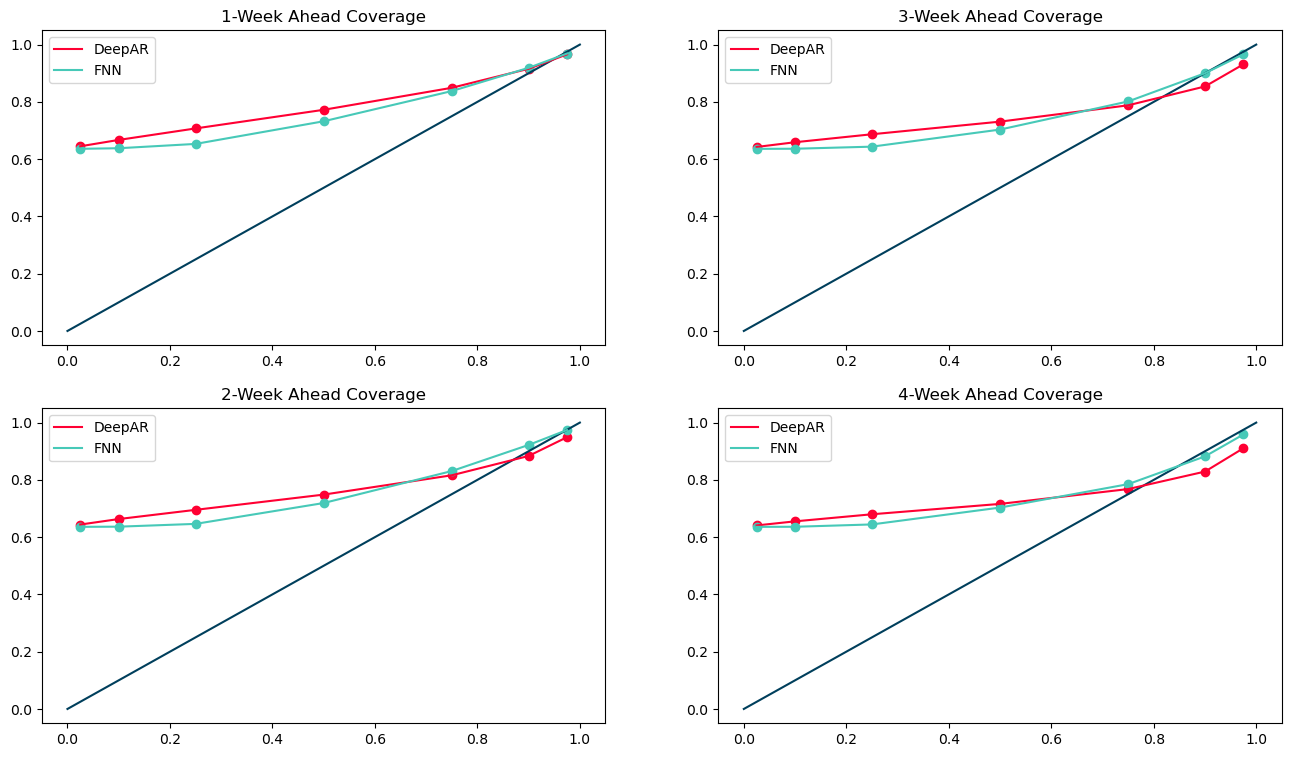

In [8]:
forecasts_dict, evaluator_df_dict = forecast_by_week(config, train, test, locations, models_dict = {"DeepAR":None, "FNN":None}, seed=0, results_dict=results_dict)

plot_coverage(config, evaluator_df_dict)
for key in evaluator_df_dict.keys():
    print(key)
    print(evaluator_df_dict[key].loc[evaluator_df_dict[key]["mean_WIS"]>0, ["item_id","mean_WIS"]])

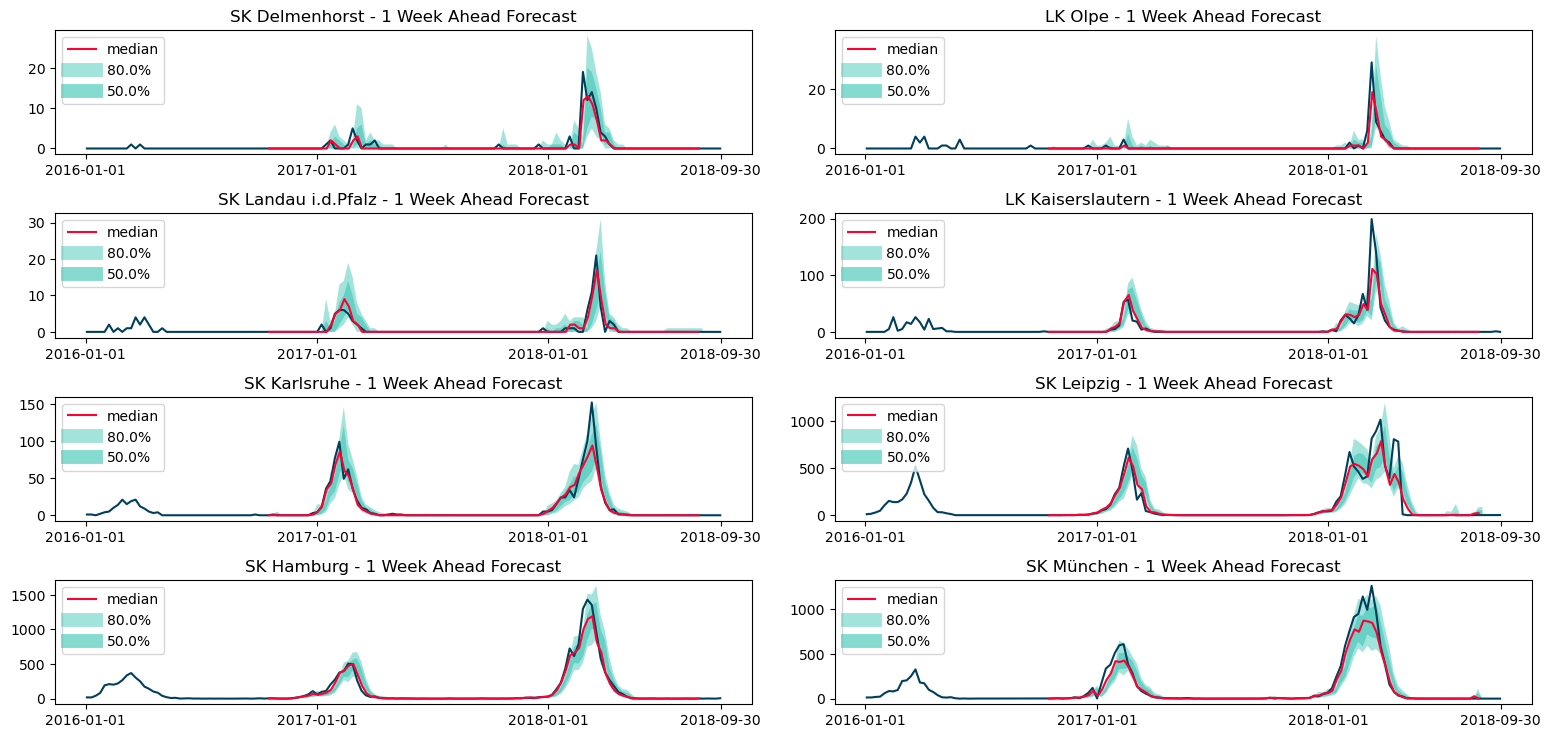

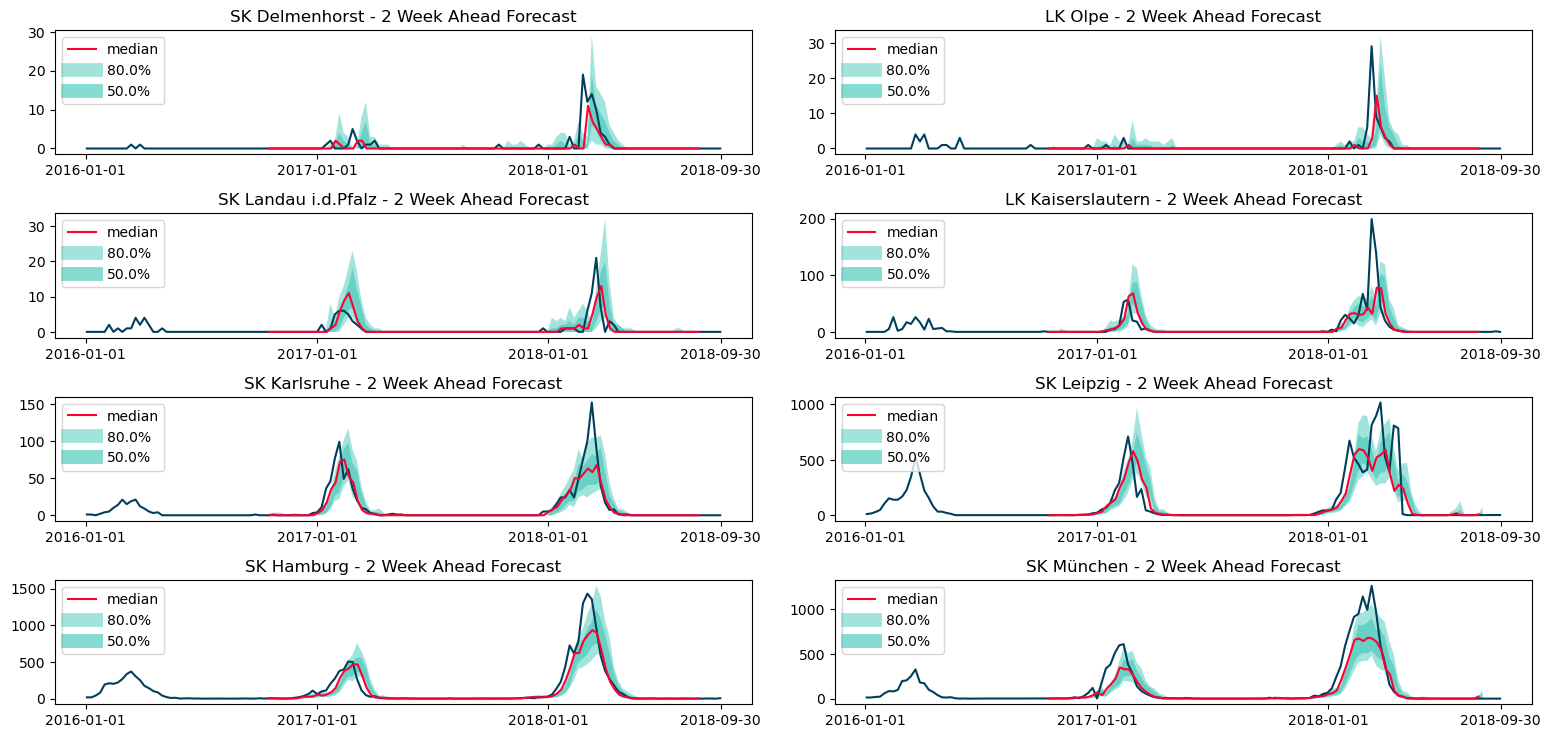

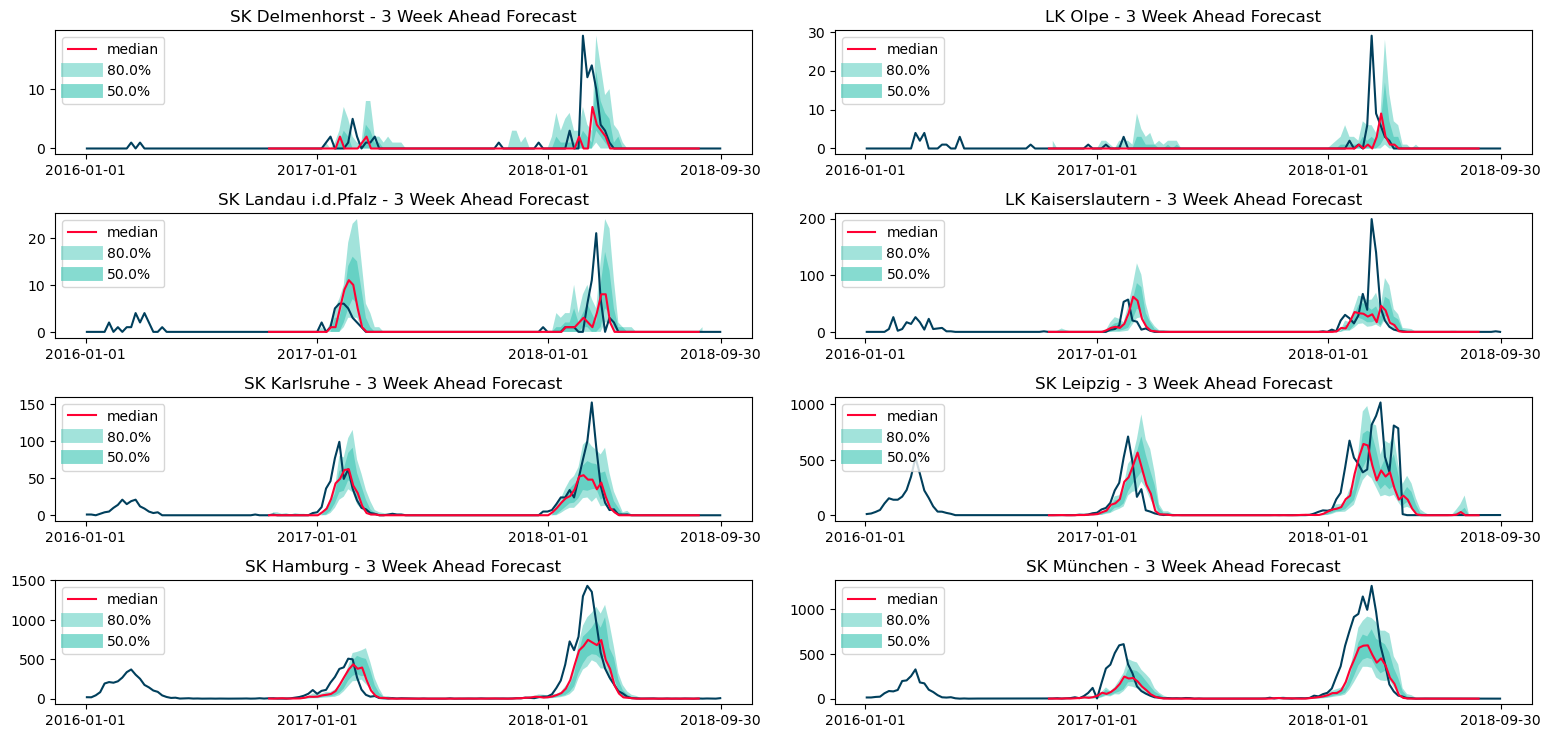

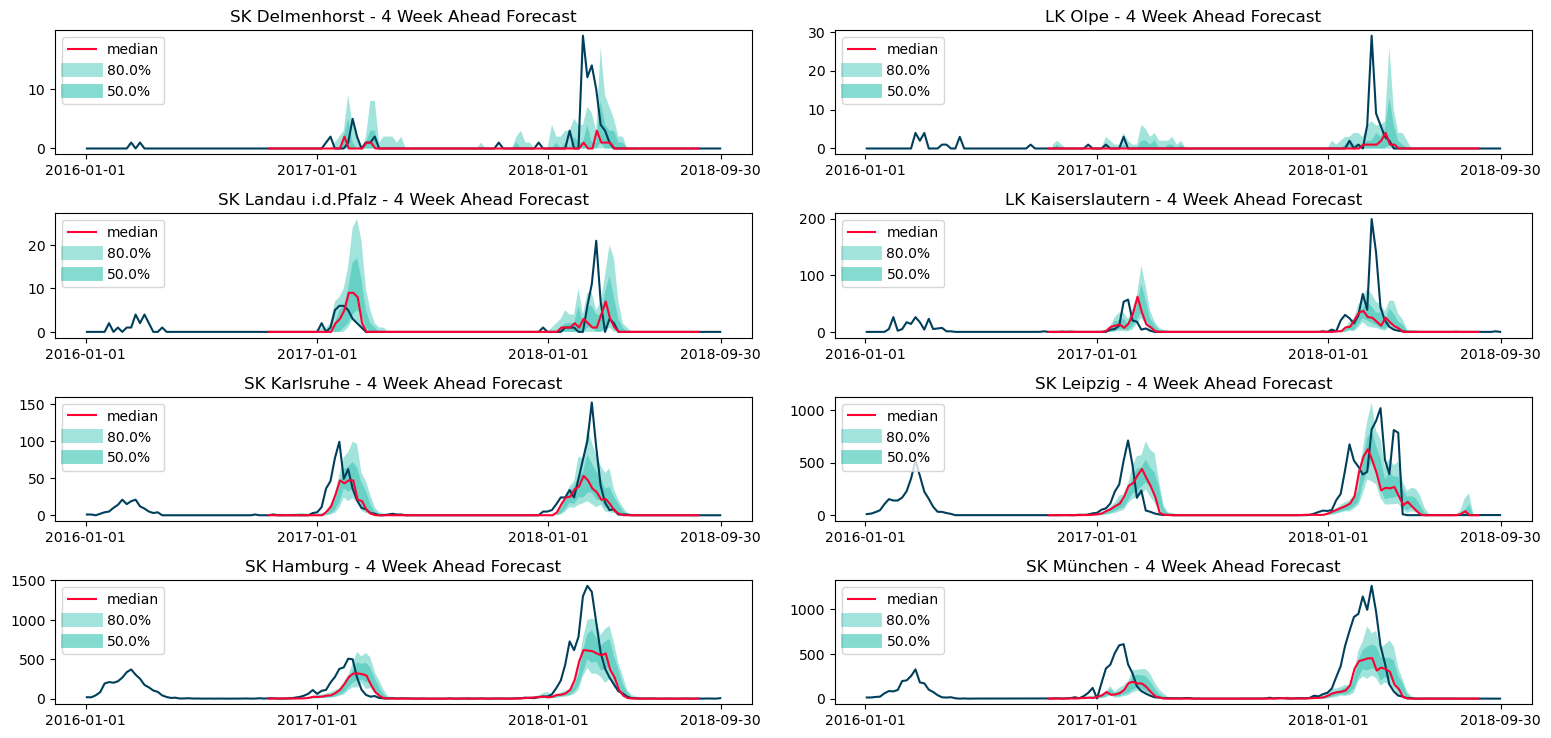

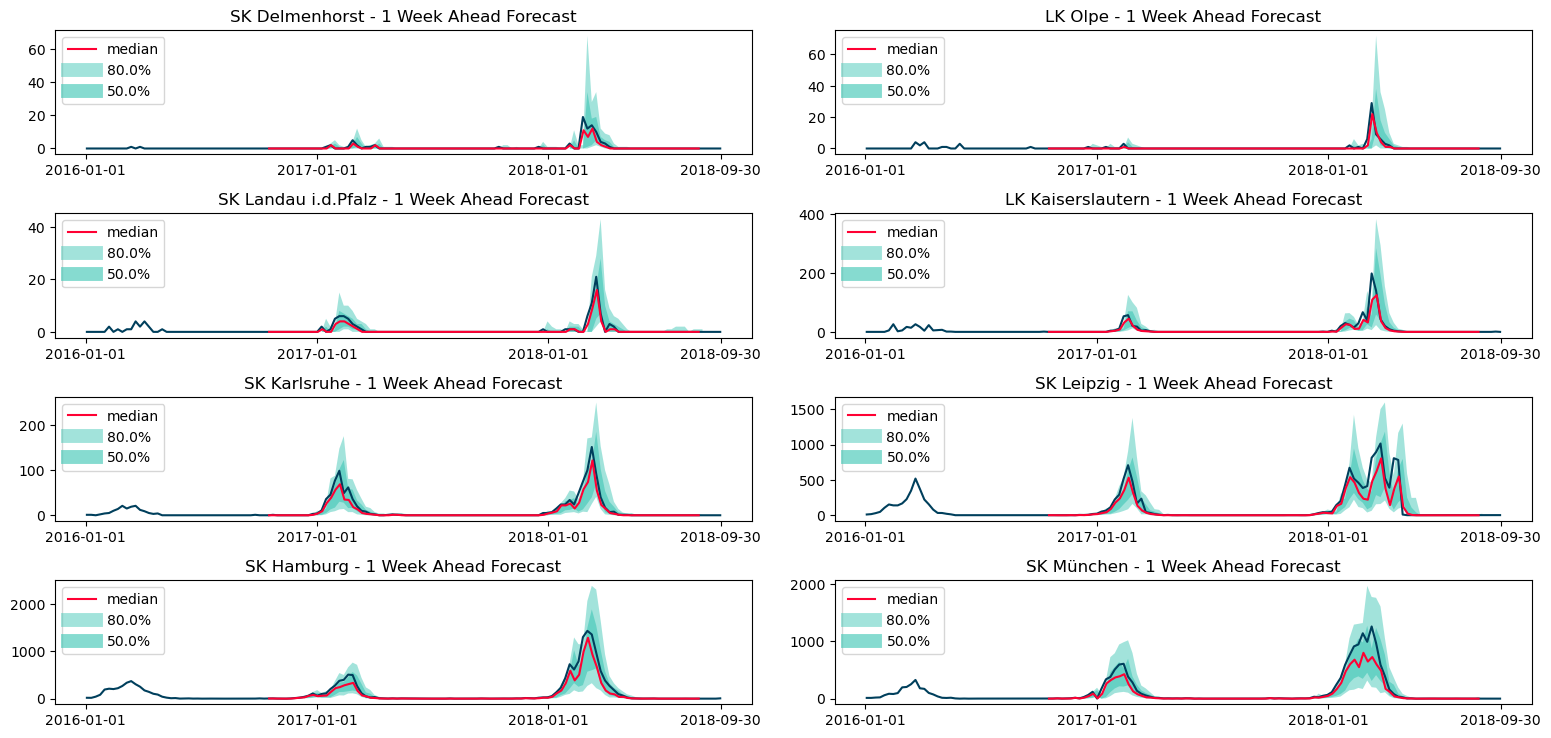

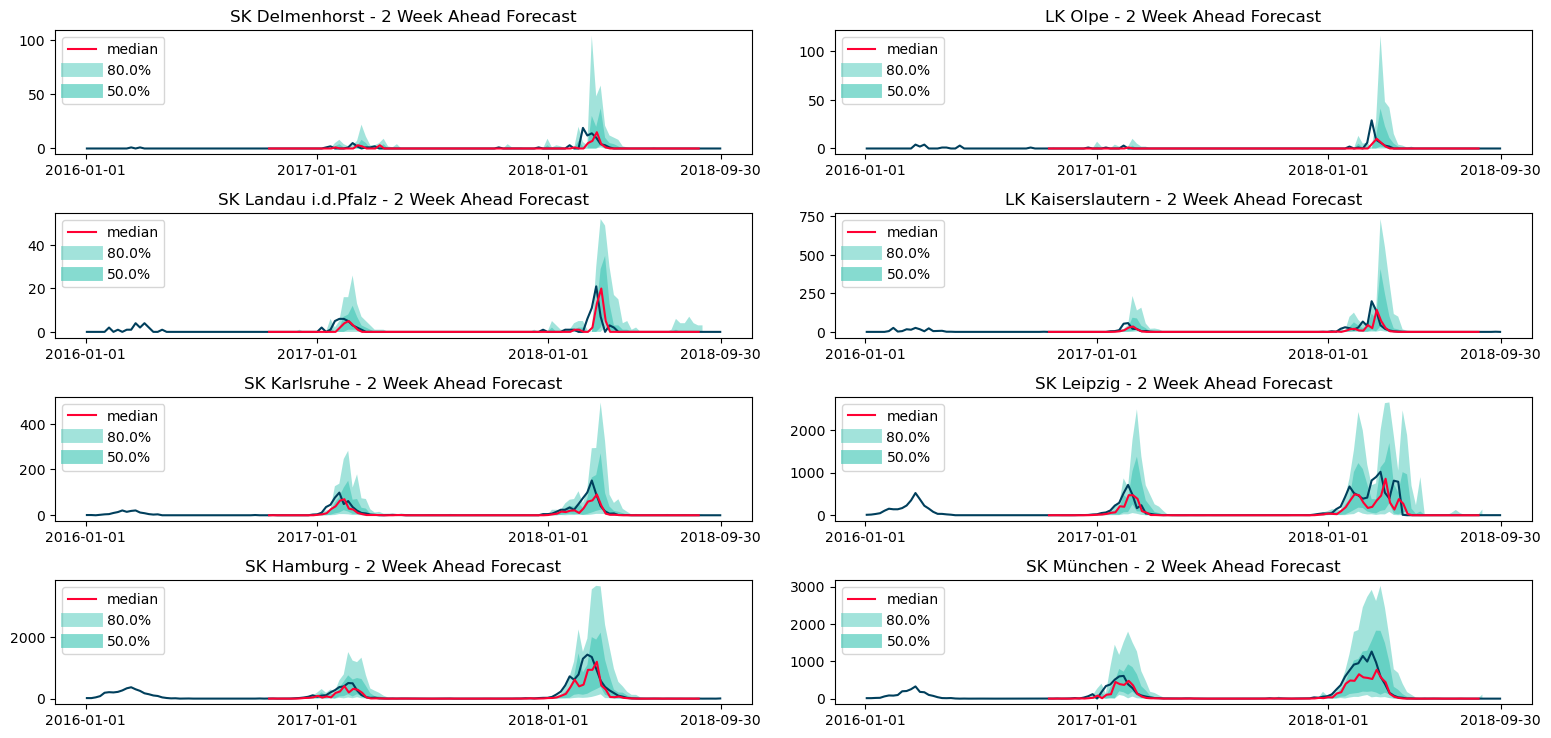

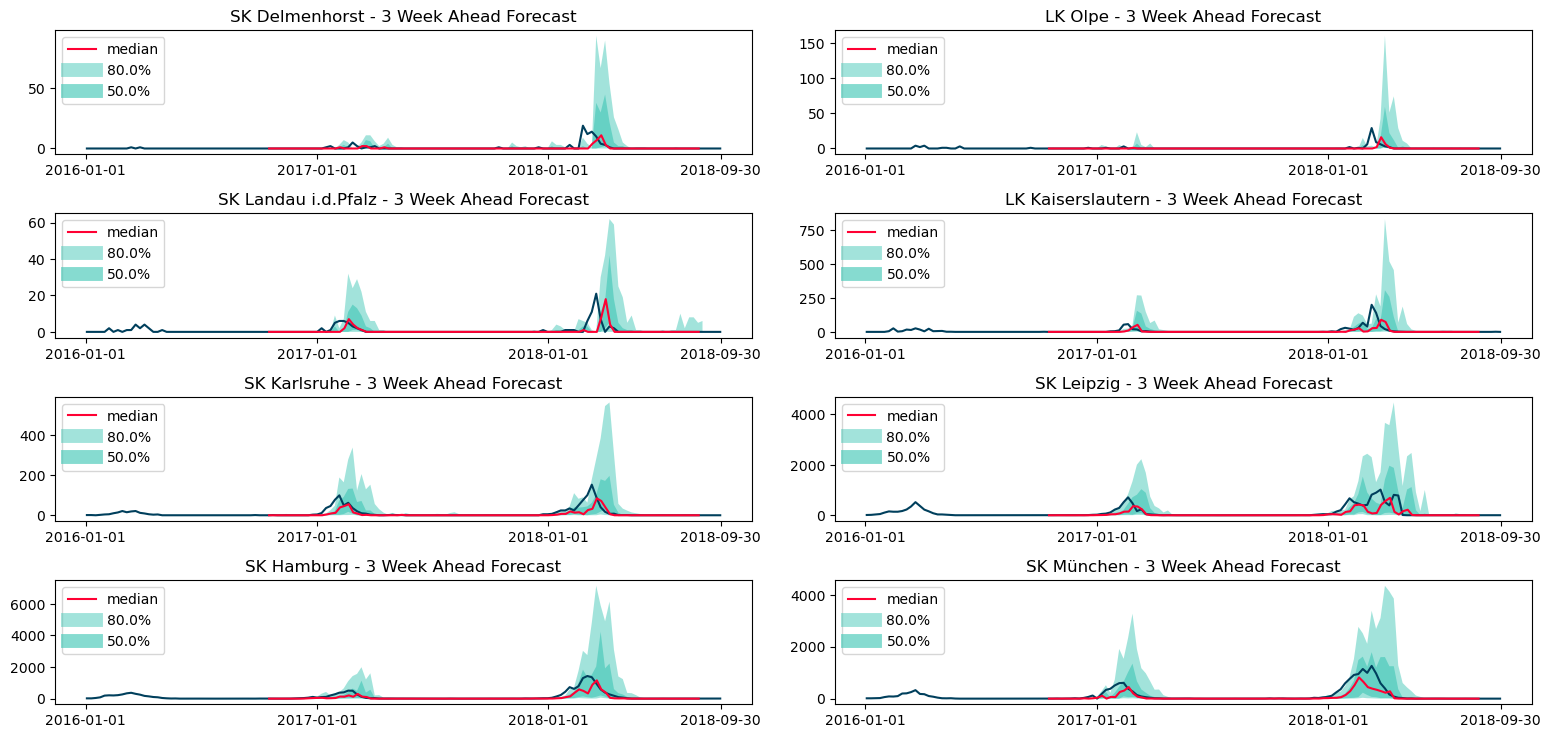

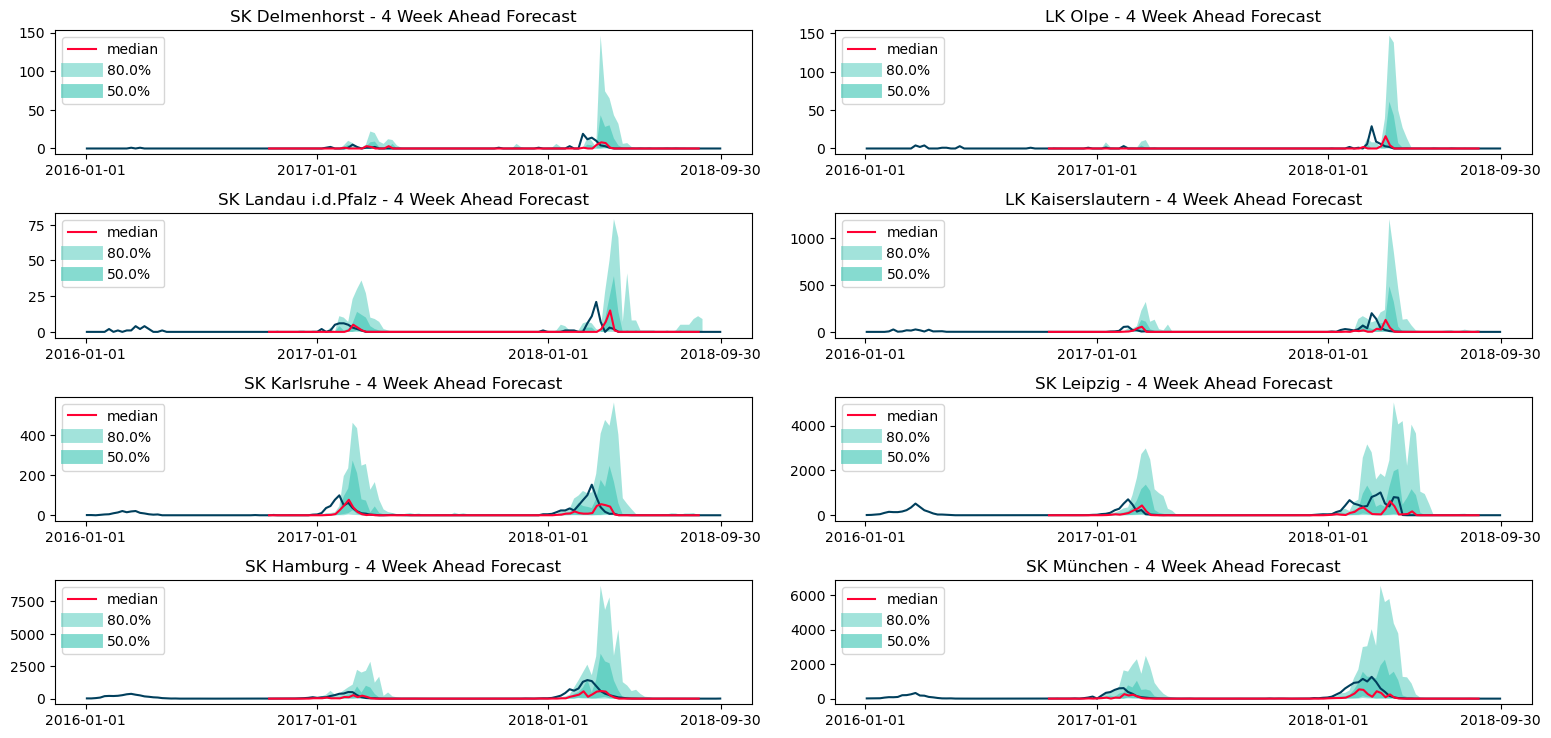

In [9]:
selected_regions = ['SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg', 'SK München']
print_forecasts_by_week(config, base_df, forecasts_dict, selected_regions, [1,2,3,4], plot_begin_at_trainstart=datetime(2016,1,1,0,0,0))          

# Combine results

DeepAR
          item_id    mean_WIS
0  aggregated {1}  279.029649
0  aggregated {2}  394.798714
0  aggregated {3}  491.593813
0  aggregated {4}  577.026590
FNN
          item_id    mean_WIS
0  aggregated {1}  295.890129
0  aggregated {2}  464.186409
0  aggregated {3}  627.079232
0  aggregated {4}  783.187174
hhh4
          item_id    mean_WIS
0  aggregated {1}  342.829701
1  aggregated {2}  421.263452
2  aggregated {3}  512.502642
3  aggregated {4}  601.897897


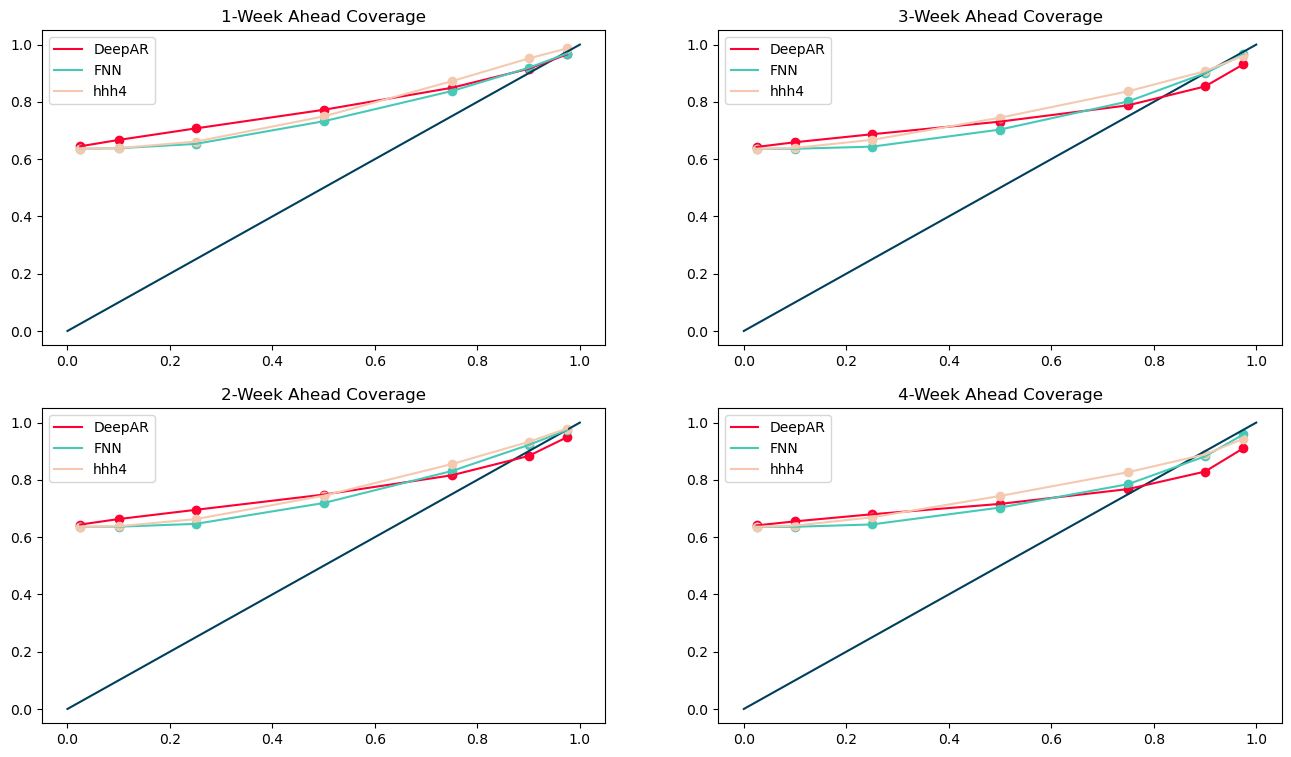

In [11]:
evaluator_df_dict["hhh4"] = evaluator_df
colors = config.colors[:3]+config.colors[12:]
plot_coverage(config, evaluator_df_dict, colors=colors)
os.chdir('/home/reffert/DeepAR_InfluenzaForecast/Notebooks/FigureCreation')
#plt.savefig(f"CoveragePlot.png")
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
for key in evaluator_df_dict.keys():
    print(key)
    print(evaluator_df_dict[key].loc[evaluator_df_dict[key]["mean_WIS"]>0, ["item_id","mean_WIS"]])

# Coverage of selected regions

In [15]:
selected_regions = ['SK Delmenhorst','LK Olpe', 'SK Landau i.d.Pfalz','LK Kaiserslautern','SK Karlsruhe', 'SK Leipzig','SK Hamburg', 'SK München']
coverage_cols = [col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "Coverage" in col]
#quantile_cols = [col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "QuantileLoss" in col]
quantile_cols = [f"QuantileLoss[{quantile}]" for quantile in config.quantiles]
selected_regions = [f"{location} "+"{"+ f"{week_ahead}"+"}" for location in locations for week_ahead in [1]]#, 2, 3, 4]]
#np.array([df[f"QuantileLoss[{quantile}]"] for quantile in config.quantiles]).mean()
for key in evaluator_df_dict.keys():
    print(key)
    selected_df = evaluator_df_dict[key].loc[evaluator_df_dict[key]["item_id"].isin(selected_regions),:]
    aggregated_df = evaluator_df_dict[key].loc[evaluator_df_dict[key]["item_id"].isin([i for i in evaluator_df_dict[key]["item_id"] if "aggregated" in i]),:]
    print(aggregated_df[["item_id"] + coverage_cols])
    selected_df["individual_WIS"] = selected_df[quantile_cols].mean(axis=1)
    #print(selected_df[["item_id", "individual_WIS"]])
    #print(selected_df[["item_id"]+[col for col in evaluator_df_dict[list(evaluator_df_dict.keys())[0]].columns if "QuantileLoss" in col]])
    #print(selected_df["individual_WIS"].mean()) # is equal to the WIS score of aggregated {1}


DeepAR
          item_id  Coverage[0.025]  Coverage[0.1]  Coverage[0.25]  \
0  aggregated {1}         0.644893       0.667114        0.707235   
0  aggregated {2}         0.643950       0.663191        0.695318   
0  aggregated {3}         0.642534       0.659069        0.686901   
0  aggregated {4}         0.640871       0.655172        0.679850   

   Coverage[0.5]  Coverage[0.75]  Coverage[0.9]  Coverage[0.975]  MAE_Coverage  
0       0.772283        0.849124       0.915487         0.965912      0.468509  
0       0.748523        0.816004       0.883510         0.949079      0.456485  
0       0.730970        0.787974       0.853841         0.931178      0.443699  
0       0.716048        0.767888       0.828964         0.910497      0.428926  
FNN
          item_id  Coverage[0.025]  Coverage[0.1]  Coverage[0.25]  \
0  aggregated {1}         0.636079       0.638090        0.653161   
0  aggregated {2}         0.635955       0.636551        0.646308   
0  aggregated {3}         0.635

/tmp/ipykernel_1410159/3234127103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["individual_WIS"] = selected_df[quantile_cols].mean(axis=1)
/tmp/ipykernel_1410159/3234127103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df["individual_WIS"] = selected_df[quantile_cols].mean(axis=1)
/tmp/ipykernel_1410159/3234127103.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 